In [216]:
# https://github.com/swar/nba_api

# Static headers for cdn requests, these never change
static_headers  = {
    'Connection': 'keep-alive',
    'Accept': 'application/json, text/plain, */*',
    'x-nba-stats-token': 'true',
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.130 Safari/537.36',
    'x-nba-stats-origin': 'stats',
    'Sec-Fetch-Site': 'same-origin',
    'Sec-Fetch-Mode': 'cors',
    'Referer': 'https://stats.nba.com/',
    'Accept-Encoding': 'gzip, deflate, br',
    'Accept-Language': 'en-US,en;q=0.9',
}


import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint

dataset_path = './datasets'

We will be analysing games played in 2019-20 between Denver Nuggets and Los Angeles Lakers. 
Example: https://github.com/swar/nba_api/blob/master/docs/examples/Finding%20Games.ipynb

In [2]:
from nba_api.stats.static import teams
from nba_api.stats.endpoints import leaguegamefinder
nba_teams = teams.get_teams()

def get_team_games(team_id: int=None, team_abbr: str=None, season: str=None, opponent_team: str=None): # -> pd.DataFrame:
    """ Get the games for a team, searchable by team_id or team_abbr. Keep only games form the given season.
    @team_id: ID of the team
    @team_abbr: Abbreviation of the team, eg. 'BOS', 'LAL'
    @season: Season in the format 'YYYY', if null then get all games
    @opponent_team: Abbreviation of the opponent team, eg. 'BOS', 'LAL'
    """
    # Find the team id if the team name is given
    if team_abbr:
        team_obj = [team for team in nba_teams if team['abbreviation'] == team_abbr][0]
        team_id = team_obj['id']

    # Get all games for the team in the given season, regular season and playoffs
    gamefinder = leaguegamefinder.LeagueGameFinder(team_id_nullable=team_id, season_type_nullable='Playoffs,Regular Season', season_nullable=season) 
    games = gamefinder.get_data_frames()[0]
    
    # If opponent team is given, keep only games against that team
    if opponent_team:
        games = games.loc[(games['MATCHUP'].str.contains(opponent_team))]
    return games


In [281]:
# Get games for Dallas from 2021-2022 versus Golden State warriors
den_games = get_team_games(team_id=None, team_abbr='DEN', season='2019-20', opponent_team='LAL')

# Get dates and id of the games
den_games = den_games[['GAME_DATE', 'GAME_ID']]



We take three random games from the df shown above, each at a different stage in season. We chose the first game in the season, the first game in the playoff and the last game of west conference finals (game 6). <br>
Main endpoint for processing play by play (pbp) data (enter your own game_id)
https://cdn.nba.com/static/json/liveData/playbyplay/playbyplay_'game_id'.json


In [4]:
import requests
import pandas as pd

# create function that gets pbp logs from the nba api with game id
def get_pbp_data(game_id):
    play_by_play_url = "https://cdn.nba.com/static/json/liveData/playbyplay/playbyplay_"+game_id+".json"
    response = requests.get(url=play_by_play_url, headers=static_headers).json()
    play_by_play = response['game']['actions']
    df = pd.DataFrame(play_by_play)
    df['gameid'] = game_id
    return df

def save_pickle(df, filename):
    df.to_pickle(filename)

There are 55 columns in the pbp dataframe and around 500 rows, depending on the number of events. Some of them are useless, so we will do some cleaning. 
Columns of interest:
- <b>actionType</b>: what happened (2pt shot, 3pt shot, rebound, turnover)
- subType: additional information about actionType (for a 2pt -> layup/dunk/midrange )
- qualifiers: additional information about actionType (for a 2pt -> pointsinthepaint,2ndchance)
- <b>personId</b>: ID of player - primary id in network
- description: more detailed description of what happened (eg. S. Curry STEAL (1 STL))
- <b>personIdsFilter</b>: IDS of players who were part of the play (eg. K. Thompson 27' 3PT  (3 PTS) (K. Looney 1 AST) -> 202691,1626172)
- playerName: last name of player, used for labels in networks
- shotResult: sucess of  the shot (Made, Missed)
- <b>assistPersonId</b>: ID of player who asisted a shot

In [283]:
den_games

,GAME_DATE,GAME_ID
0,2020-09-26,0041900315
1,2020-09-24,0041900314
2,2020-09-22,0041900313
3,2020-09-20,0041900312
4,2020-09-18,0041900311
21,2020-08-10,0021901296
37,2020-02-12,0021900817
64,2019-12-22,0021900443
74,2019-12-03,0021900304


In [287]:
# Setup games of interest
games_list = {'0021900304': "2019-12-03	", '0041900311':"2020-09-18", '0041900315':"2020-09-26"}

# Get the play by play data for each game
for game,date in games_list.items():
    pbp = get_pbp_data(game)

    # Save the data to a pickle file
    save_pickle(pbp, 'pbp_'+game+'.pkl')


# Read the pickle file
pbp = pd.read_pickle('pbp_0021900304.pkl')

# Remove some columns
col_rem = ['x', 'y', 'edited', 'xLegacy', 'yLegacy', 'side', 'playerName', 
           'officialId', 'jumpBallRecoveredName', 'jumpBallRecoverdPersonId',
           'jumpBallWonPlayerName', 'jumpBallWonPersonId', 'jumpBallLostPlayerName',
           'jumpBallLostPersonId']

pbp = pbp.drop(col_rem, axis=1)


# Change some column names
col_rename = {'assistPlayerNameInitial': 'assistPlayer', 'playerNameI': 'playerName'}
pbp = pbp.rename(columns=col_rename)

# Change teamId to int if they are not nan
pbp['teamId'] = pbp['teamId'].apply(lambda x: int(x) if not pd.isnull(x) else x)
pbp['personId'] = pbp['personId'].apply(lambda x: int(x) if not pd.isnull(x) else x)
pbp['assistPersonId'] = pbp['assistPersonId'].apply(lambda x: int(x) if not pd.isnull(x) else x)



In [183]:
def get_team_network(team_ids: list, pbp):
    """
    @team_ids: List of team ids, eg. [1610612744, 1610612745]
    """
    network_dict = {team_id: nx.MultiDiGraph() for team_id in team_ids}

    for id in team_ids:
        # Add two nodes for shot result
        network_dict[id].add_node(1, playerName='Made', shot_result='Made', teamId=0)
        network_dict[id].add_node(2, playerName='Missed', shot_result='Missed', teamId=0)

    # Iterate through the rows and print the description
    for index, row in pbp.iterrows():
        # Add only team events
        if row['teamId'] == row['teamId']:

            # Create a node for each player and add it to the graph
            if row['personId']:
                # Add the player to the team network
                network_dict[row['teamId']].add_node(int(row['personId']), playerName=row['playerName'], teamId=int(row['teamId']))

            # Check if event is a shot attempt
            if row['shotResult'] in ['Made', 'Missed']:
                # Get the shooter and assist person ids
                shooter = row['personId']
                assist = row['assistPersonId']

                # Check if assist is nan
                if assist == assist:
                    # Add team_network node to the graph
                    network_dict[row['teamId']].add_node(int(assist), playerName=row['assistPlayer'], teamId=int(row['teamId']))
                    # Connect the assist to the shooter
                    network_dict[row['teamId']].add_edge(int(assist), shooter, action='assist', event_type=row['actionType'], weight=1)

                connect_to = 1 if row['shotResult'] == 'Made' else 2
                # Connect the shooter to the shot result
                network_dict[row['teamId']].add_edge(shooter, connect_to, action='shot', event_type=row['actionType'], subType = row['subType'], weight = 1)

    return network_dict.values()

In [288]:
def convert_asists(multi_graph):
    # Join all assist edges between two players into one edge with weight
    assist_edges = [(u, v, d) for u, v, k, d in multi_graph.edges(keys=True, data=True) if d['action'] == 'assist']

    # Sum the weights of the assist edges between two players
    assist_edges = [(u1, v1, 
                     len([d['weight'] for u, v, d in assist_edges if (u == u1 and v == v1) or (u == v1 and v == u1)])) 
                     for u1, v1, d1 in assist_edges]
    
    # Remove the assist edges from the graph
    multi_graph.remove_edges_from([(u, v, k) for u, v, k, d in multi_graph.edges(keys=True, data=True) if d['action'] == 'assist'])


    # Add the assist edges with the summed weights
    multi_graph.add_weighted_edges_from(assist_edges, weight='weight', action='assist')

    return multi_graph


def draw_network(team_network):

    df = pd.DataFrame(index=team_network.nodes(), columns=team_network.nodes())
    for row, data in nx.shortest_path_length(team_network):
        for col, dist in data.items():
            df.loc[row,col] = dist

    df = df.fillna(df.max().max())

    # Convert the multi graph to a directed graph
    weighted_graph = convert_asists(team_network)

    plt.figure(figsize =(15, 18))

    # Use kawai layout to draw the graph
    pos = nx.kamada_kawai_layout(weighted_graph, dim = 2, dist=df.to_dict())

    # Get the assist edges from the graph
    assist_edges = [(u, v) for u, v, d in weighted_graph.edges(data=True) if d['action'] == 'assist']

    # Get the assist weights from the graph
    assist_weights = [d['weight'] for u, v, d in weighted_graph.edges(data=True) if d['action'] == 'assist']

    # Get the shot edges from the graph
    shot_edges = [(u, v) for u, v, d in weighted_graph.edges(data=True) if d['action'] == 'shot']

    # Get the shot weights from the graph
    shot_weights = [d['weight'] for u, v, d in weighted_graph.edges(data=True) if d['action'] == 'shot']

    # Draw the assist edges
    nx.draw_networkx_edges(weighted_graph, pos, edgelist=assist_edges, width=assist_weights, alpha=0.5, edge_color='b')

    # Draw the shot edges
    nx.draw_networkx_edges(weighted_graph, pos, edgelist=shot_edges, width=shot_weights, alpha=0.5, edge_color='r')

    # Get node size based on degree
    node_size = [weighted_graph.degree(node) * 10 for node in weighted_graph.nodes]

    # Draw the nodes
    nx.draw_networkx_nodes(weighted_graph, pos, nodelist=weighted_graph.nodes, node_size=node_size, node_color='g')

    # Draw the labels
    nx.draw_networkx_labels(weighted_graph, pos, labels={node: weighted_graph.nodes[node]['playerName'] for node in weighted_graph.nodes})

    # Set the title
    plt.title(team_network.name + " Network")

    # Show the plot
    plt.show()


C:\Users\Žan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


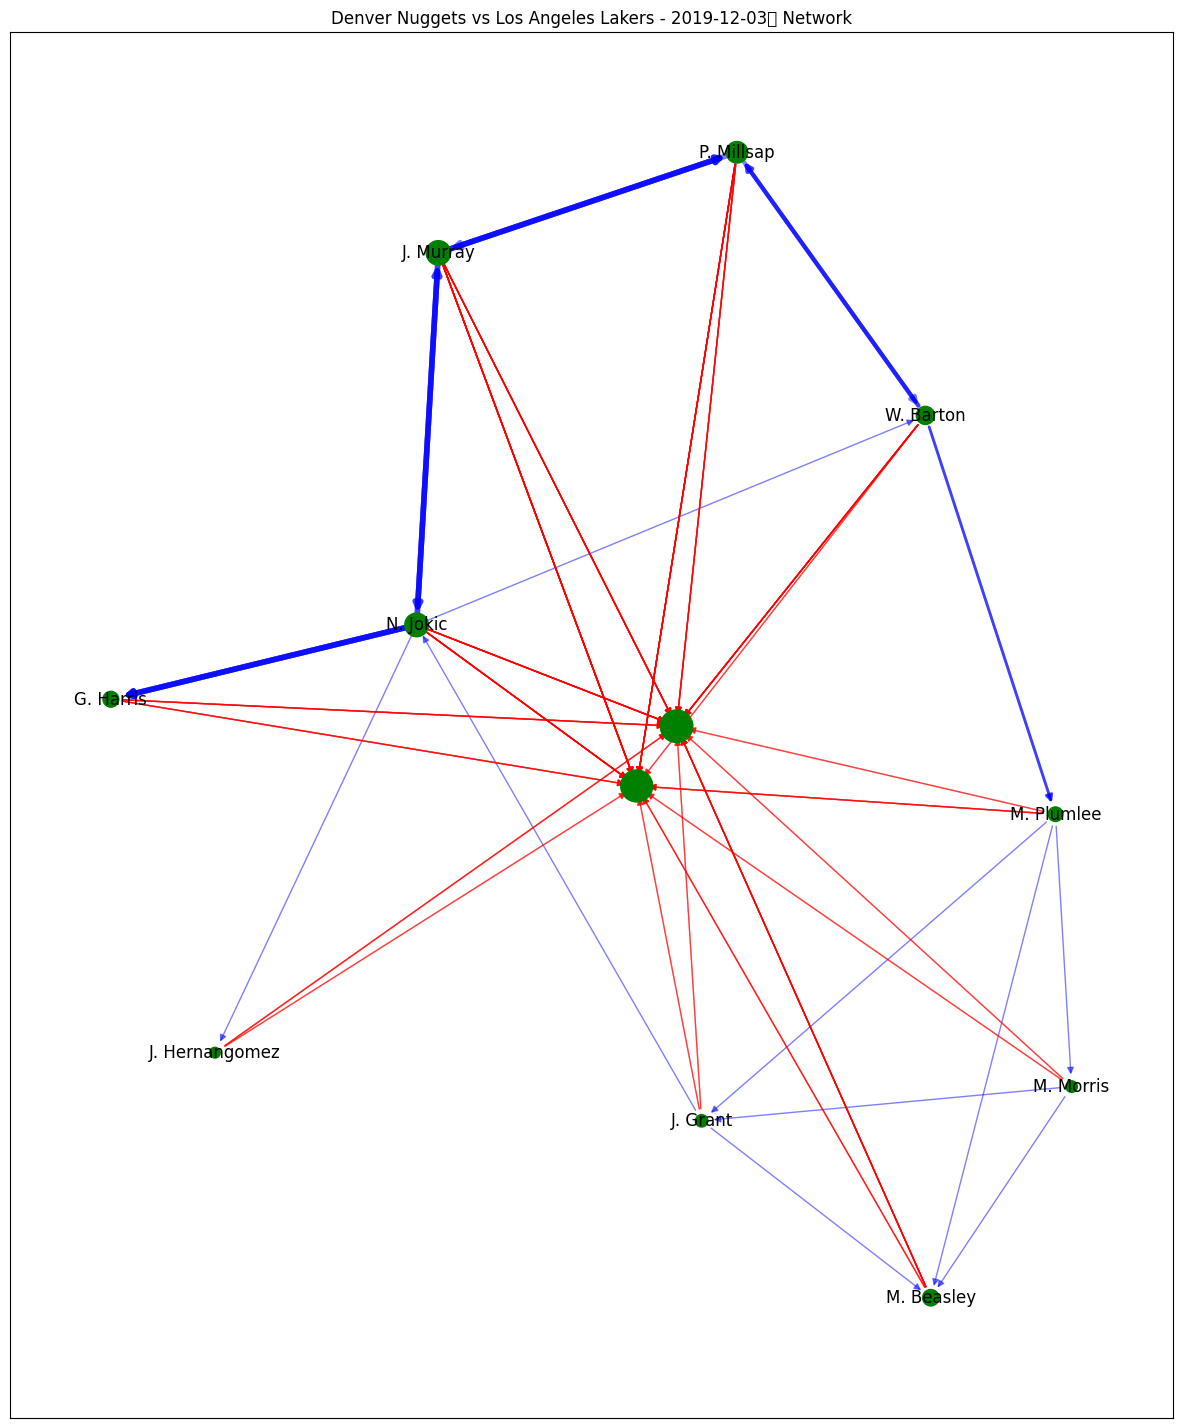

In [289]:
for game, date in games_list.items():


    # Get Denver network
    den_network, lal_network = get_team_network([1610612743,1610612747] , pbp)
    den_network.name = 'Denver Nuggets vs Los Angeles Lakers - ' + date

    draw_network(den_network)

    break

In [76]:
# Dataset created by the script from article https://github.com/AniMadurkar/NBA-Flow-Network-Analysis/tree/main
# Read data from csv
players = pd.read_csv(dataset_path + '/2019_Playoffs_Players.csv')
teams = pd.read_csv(dataset_path + '/2019_Playoffs.csv')
players

,Unnamed: 0,GAME_ID,PLAYER_ID,PLAYER_NAME_LAST_FIRST_home,TEAM_NAME_home,TEAM_ID_home,TEAM_ABBREVIATION_home,PASS_TYPE_home,G_home,PASS_TO_home,...,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS,POSITION,mean,std
0,0,41900311,2544,"James, LeBron",Los Angeles Lakers,1610612747,LAL,made,1,"Kuzma, Kyle",...,12.0,0.0,0.0,3.0,2.0,15.0,15.0,Forward,0.082776,0.098088
1,1,41900311,2544,"James, LeBron",Los Angeles Lakers,1610612747,LAL,made,1,"Caruso, Alex",...,12.0,0.0,0.0,3.0,2.0,15.0,15.0,Forward,0.082776,0.098088
2,2,41900311,2544,"James, LeBron",Los Angeles Lakers,1610612747,LAL,made,1,"Caldwell-Pope, Kentavious",...,12.0,0.0,0.0,3.0,2.0,15.0,15.0,Forward,0.082776,0.098088
3,3,41900311,2544,"James, LeBron",Los Angeles Lakers,1610612747,LAL,made,1,"Davis, Anthony",...,12.0,0.0,0.0,3.0,2.0,15.0,15.0,Forward,0.082776,0.098088
4,4,41900311,2544,"James, LeBron",Los Angeles Lakers,1610612747,LAL,made,1,"Morris, Markieff",...,12.0,0.0,0.0,3.0,2.0,15.0,15.0,Forward,0.082776,0.098088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,266,41900315,1628398,"Kuzma, Kyle",Los Angeles Lakers,1610612747,LAL,made,1,"Caruso, Alex",...,1.0,0.0,1.0,0.0,3.0,8.0,0.0,Forward,0.082776,0.098088
267,267,41900315,1628398,"Kuzma, Kyle",Los Angeles Lakers,1610612747,LAL,made,1,"McGee, JaVale",...,1.0,0.0,1.0,0.0,3.0,8.0,0.0,Forward,0.082776,0.098088
268,268,41900315,1628398,"Kuzma, Kyle",Los Angeles Lakers,1610612747,LAL,made,1,"Rondo, Rajon",...,1.0,0.0,1.0,0.0,3.0,8.0,0.0,Forward,0.082776,0.098088
269,269,41900315,1628398,"Kuzma, Kyle",Los Angeles Lakers,1610612747,LAL,made,1,"Howard, Dwight",...,1.0,0.0,1.0,0.0,3.0,8.0,0.0,Forward,0.082776,0.098088


In [20]:
# Get stats from game 41900315
game_id = 41900315
game_players = players.loc[players['GAME_ID'] == game_id]
game_teams = teams.loc[teams['GAME_ID'] == game_id]
